# SetUP

In [1]:
setwd("/lustre/user/liclab/jialm/Project/SCOPEC/analysis/fithicLoop/RG_eN/")

In [2]:
suppressPackageStartupMessages({
library(dplyr)
library(tidyverse)
library(data.table)
library(ggplot2)
library(edgeR)
library(RColorBrewer)
library(GenomicRanges)
library(ComplexHeatmap)
#library(igraph)
})

In [3]:
calculate_cutoff <- function(inputVector, drawPlot=TRUE,...){
 	inputVector <- sort(inputVector)
	inputVector[inputVector<0]<-0 #set those regions with more control than ranking equal to zero
	slope <- (max(inputVector)-min(inputVector))/length(inputVector) #This is the slope of the line we want to slide. This is the diagonal.
	xPt <- floor(optimize(numPts_below_line,lower=1,upper=length(inputVector),myVector= inputVector,slope=slope)$minimum) #Find the x-axis point where a line passing through that point has the minimum number of points below it. (ie. tangent)
	y_cutoff <- inputVector[xPt] #The y-value at this x point. This is our cutoff.
	
	if(drawPlot){  #if TRUE, draw the plot
		plot(1:length(inputVector),inputVector,type="p",pch=20,lwd=.75,xlab="rank",ylab="sum(-log10Pvalue)")
		b <- y_cutoff-(slope* xPt)
		abline(v= xPt,h= y_cutoff,lty=2,col=8,lwd=.75)
		points(xPt,y_cutoff,pch=20,cex=1.5,col=2)
		abline(coef=c(b,slope),col=2,lwd=.75)
		title(paste("x=",xPt,"\ny=",signif(y_cutoff,3),sep=""))
		axis(1,sum(inputVector==0),sum(inputVector==0),col.axis="pink",col="pink") #Number of regions with zero signal
	}
	return(list(absolute=y_cutoff,overMedian=y_cutoff/median(inputVector),overMean=y_cutoff/mean(inputVector)))
}

In [4]:
numPts_below_line <- function(myVector,slope,x){
	yPt <- myVector[x]
	b <- yPt-(slope*x)
	xPts <- 1:length(myVector)
	return(sum(myVector<=(xPts*slope+b)))
}

# macaca

## load promoter

In [7]:
promoter <- read.table("../../../../../Annotation/promoter/rheMac10.Refseq.all.genes.2kb.promoter.bed")
colnames(promoter) <- c("seqnames","start","end","symbol")

In [8]:
promoter.gr <- makeGRangesFromDataFrame(promoter,keep.extra.columns = T)

## call SIO

In [74]:
RGL <- read.table("./macaca/macaca.RG_intraOnly.spline_pass1.res25000.significances.Q0.00001.count3.50kb.10Mb.txt")%>% mutate(v2=V2-12500,v3=V2+12500,v4=V4-12500,v5=V4+12500) %>% select(V1,v2,v3,V3,v4,v5,V5,V7)
#iPCL <- read.table("/lustre/user/liclab/cuizj/OCEANC2.0/OCEANC2.0_newdata/macaca/data_20220930/allValidPairs/hicpro-out/IPC_25kb_fithic/macaca.iPC_nan_25kb/macaca.RG_intraOnly.spline_pass1.res25000.significances.Q0.00001.count3.50kb.10Mb.txt")%>% mutate(v2=V2-12500,v3=V2+12500,v4=V4-12500,v5=V4+12500) %>% select(V1,v2,v3,V3,v4,v5,V5,V7)
eNL <- read.table("./macaca/macaca.eN_intraOnly.spline_pass1.res25000.significances.Q0.00001.count3.50kb.10Mb.txt")%>% mutate(v2=V2-12500,v3=V2+12500,v4=V4-12500,v5=V4+12500) %>% select(V1,v2,v3,V3,v4,v5,V5,V7)

In [78]:
dim(RGL)
dim(eNL)

[1] 8505    8

[1] 4245    8

In [23]:
colnames(RGL) <- c("c1","s1","e1","c2","s2","e2","counts","q")
colnames(eNL) <- c("c1","s1","e1","c2","s2","e2","counts","q")

In [26]:
RGL <- RGL%>%
#filter(!(c1=="chr15"&s1==20550000)) %>% filter(!(c2=="chr15"&s2==20550000))%>%
mutate(ID1=paste(c1,s1,e1,sep="-"),ID2=paste(c2,s2,e2,sep="-"))
eNL <- eNL%>%
#filter(!(c1=="chr15"&s1==20550000)) %>% filter(!(c2=="chr15"&s2==20550000))%>%
mutate(ID1=paste(c1,s1,e1,sep="-"),ID2=paste(c2,s2,e2,sep="-"))

In [27]:
RG.io <- rbind(RGL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c2,-s2,-e2,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ"),
      RGL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c1,-s1,-e1,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ")) %>%
group_by(c,s,e) %>% 
summarise(sumC=sum(counts),
          sumFDR=sum(logQ),
          N=n()) %>% 
arrange(sumFDR) 
RG.io$rank <- 1:dim(RG.io)[1]

`summarise()` has grouped output by 'c', 's'. You can override using the `.groups` argument.


In [28]:
eN.io <- rbind(eNL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c2,-s2,-e2,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ"),
      eNL %>% mutate(logQ=-log10(q)) %>% dplyr::select(-c1,-s1,-e1,-ID1,-ID2) %>%
      set_names("c","s","e","counts","q","logQ")) %>%
group_by(c,s,e) %>% 
summarise(sumC=sum(counts),
          sumFDR=sum(logQ),
          N=n()) %>% 
arrange(sumFDR) 
eN.io$rank <- 1:dim(eN.io)[1]

`summarise()` has grouped output by 'c', 's'. You can override using the `.groups` argument.


In [51]:
quantile(RG.io$sumFDR,c(.3,.7,.5))
quantile(eN.io$sumFDR,c(.3,.7,.5))

30%       70%       50% 
 6.899827 17.812209 10.644019

30%       70%       50% 
 6.428403 13.235976  8.319892

$absolute
[1] 39.03516

$overMedian
[1] 3.667333

$overMean
[1] 2.251392

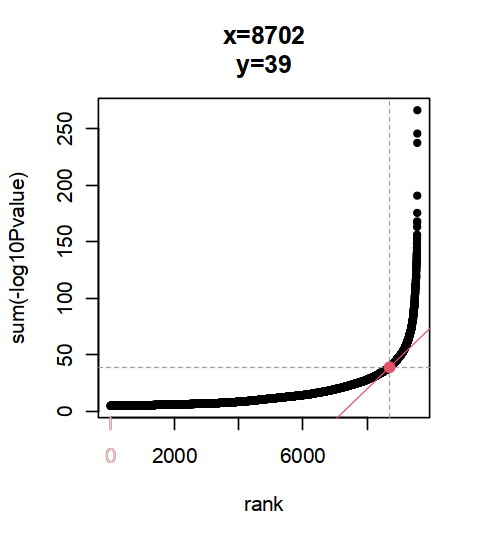

$absolute
[1] 22.81008

$overMedian
[1] 2.741631

$overMean
[1] 1.829481

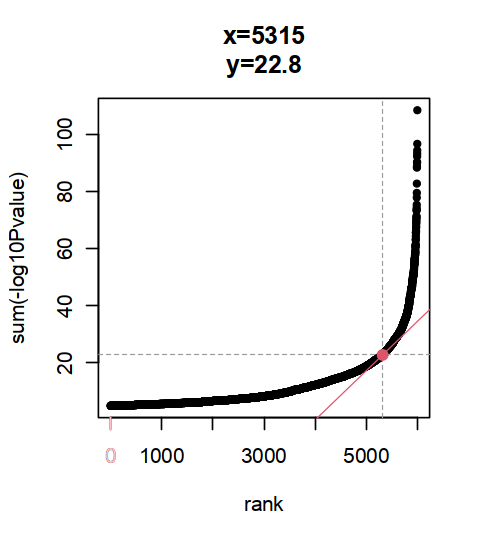

In [30]:
options(repr.plot.width=4,repr.plot.height=4.5)
calculate_cutoff(RG.io$sumFDR)
calculate_cutoff(eN.io$sumFDR)

In [34]:
all.SIO2WIO <- dplyr::full_join(RG.io[,c(1:3,5)],eN.io[,c(1:3,5)],by=c("c","s","e")) %>%
replace(is.na(.),0) 

In [37]:
all.SIO2WIO$rowSum <- rowSums(all.SIO2WIO[,4:5])

In [63]:
G1 <- all.SIO2WIO %>% 
         as.data.frame() %>%
arrange(desc(sumFDR.x))%>% filter(sumFDR.y <= 10,sumFDR.x>=20)

In [67]:
G2 <- all.SIO2WIO %>% 
         as.data.frame() %>%
arrange(desc(sumFDR.y))%>% filter(sumFDR.y >= 20,sumFDR.x<=10)

In [90]:
G3 <- all.SIO2WIO %>% 
         as.data.frame() %>%
arrange(desc(sumFDR.y),) %>% 
filter(sumFDR.x >= 20,sumFDR.y>=20)

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


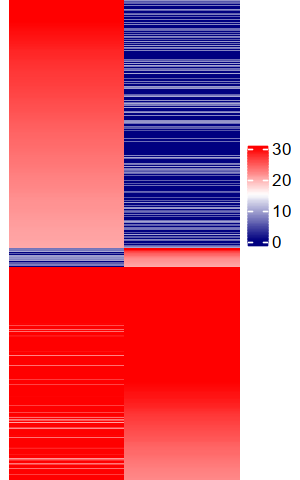

In [96]:
options(repr.plot.width=2.5,repr.plot.height=4)
pheatmap(rbind(G1,G2,G3) %>% 
         dplyr::select(sumFDR.x,sumFDR.y),
         breaks=c(0,30),cluster_cols = F,cluster_rows = F,cellheight = .2,
         col=colorRampPalette(c("navy","white","red1"))(500)
         )

In [72]:
allGroup <- rbind(G1 %>% mutate(G="G1"),
G2 %>% mutate(G="G2"),
G3 %>% mutate(G="G3"))

In [79]:
write.table(allGroup,"./macaca_RGeN_allGroup_IO.bed",col.names = F,row.names = F,quote=F,sep="\t")

In [25]:
RG.gene <- read.table("./RG.final.res")
eN.gene <- read.table("./eN.final.res")

In [26]:
G1.gene <- dplyr::left_join(G1,RG.gene,by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 
G2.gene <- dplyr::left_join(G2,iPC.gene,by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 
G3.gene <- dplyr::left_join(G3,eN.gene,by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 

In [27]:
G4.gene <- dplyr::left_join(G1,rbind(RG.gene,iPC.gene),by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 

In [28]:
G5.gene <- dplyr::left_join(G1,rbind(RG.gene,iPC.gene),by=c("c"="V1","s"="V2","e"="V3")) %>%
select(c,s,e,sumFDR.x,sumFDR.y,sumFDR,V8) %>% distinct() 

In [29]:
RNA <- read.table("../sc_human_average_CPM.txt") %>% filter(RG>0.5 | IPC >0.5 | eN >0.5 | iN >0.5)
RNA$symbol <- rownames(RNA)

In [30]:
G1.RNA <- dplyr::inner_join(G1.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)
G2.RNA <- dplyr::inner_join(G2.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)
G3.RNA <- dplyr::inner_join(G3.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)
G4.RNA <- dplyr::inner_join(G4.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)
G5.RNA <- dplyr::inner_join(G5.gene,RNA,by=c("V8"="symbol")) %>% select(-iN) %>%
mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1)) %>% 
mutate(mean=(logRG+logIPC+logeN)/3,RG=logRG-mean,IPC=logIPC-mean,eN=logeN-mean)

In [31]:
G1.RNA.adjust <- G1.RNA %>% filter(!V8 %in% G3.RNA$V8) %>%
filter(!V8 %in% G2.RNA$V8)
G2.RNA.adjust <- G2.RNA %>% filter(!V8 %in% G1.RNA$V8) %>%
filter(!V8 %in% G3.RNA$V8)
G3.RNA.adjust <- G3.RNA %>% filter(!V8 %in% G1.RNA$V8) %>%
filter(!V8 %in% G2.RNA$V8)

In [33]:
library(ComplexHeatmap)

In [34]:
G1.ha <- rowAnnotation(
  foo = anno_mark(
    at = G1.RNA.adjust %>% mutate(rank=1:dim(G1.RNA.adjust)[1]) %>% 
filter(RG>=2.5,IPC<=-0.5,eN<=-0.5) %>%
filter(!grepl("-AS1",.$V8))%>% .$rank, 
    labels = G1.RNA.adjust %>% mutate(rank=1:dim(G1.RNA.adjust)[1]) %>% 
filter(RG>=2.5,IPC<=-0.5,eN<=-0.5)%>%
filter(!grepl("-AS1",.$V8)) %>% .$V8)
  )

G2.ha <- rowAnnotation(
  foo = anno_mark(
    at = G2.RNA.adjust %>% mutate(rank=1:dim(G2.RNA.adjust)[1]) %>% 
filter(IPC>=2.4,eN<=1,RG<=1)%>%
filter(!grepl("-AS1",.$V8))%>% .$rank, 
    labels = G2.RNA.adjust %>% mutate(rank=1:dim(G2.RNA.adjust)[1]) %>% 
filter(IPC>=2.4,eN<=1,RG<=1)%>%
filter(!grepl("-AS1",.$V8))%>% .$V8)
  )

G3.ha <- rowAnnotation(
  foo = anno_mark(
    at = G3.RNA.adjust %>% mutate(rank=1:dim(G3.RNA.adjust)[1]) %>% 
filter(eN>=2.4,IPC<=1,RG<=1)%>%
filter(!grepl("-AS1",.$V8),logeN>=9)%>% .$rank, 
    labels = G3.RNA.adjust %>% mutate(rank=1:dim(G3.RNA.adjust)[1]) %>% 
filter(eN>=2.4,IPC<=1,RG<=1)%>%
filter(!grepl("-AS1",.$V8),logeN>=9)%>% .$V8)
  )

In [35]:
markPE <- read.table("./RGiPCeN_allGroup_IO.bed.PromoterOrEnhancer") %>%
mutate(CRE=case_when(V5=="."  ~ "distal",
                     V5!="."  ~ "promoter")) %>% 
select(V1,V2,V3,CRE) %>% distinct()

In [36]:
ann_colors=list(CRE=c(distal="black",promoter="lightgray")) 

In [98]:
options(repr.plot.width=2.5,repr.plot.height=4)
pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG1_RNAseq.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G1.RNA.adjust[,c(8,9,10)],
         breaks=c(-1,2),right_annotation = G1.ha,
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("white","slategray2","midnightblue"))(500)
         )
dev.off()

pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG1_interactiveScore.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G1.RNA.adjust[,c(4:6)],
         breaks=c(0,40),annotation_row=dplyr::left_join(G1.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) %>% 
                         select(CRE),annotation_colors=ann_colors,
         cluster_cols = F,cluster_rows = F,cellheight = .15,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500)
         )
dev.off()

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


png 
  2

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


png 
  2

In [100]:
pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG2_RNAseq.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G2.RNA.adjust[,c(8,9,10)],
         breaks=c(-1,2),right_annotation = G2.ha,
         cluster_cols = F,cluster_rows = F,cellheight = .3,cellwidth = 30,
         col=colorRampPalette(c("white","slategray2","midnightblue"))(500)
         )
dev.off()

pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG2_interactiveScore.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G2.RNA.adjust[,c(4:6)],
         breaks=c(0,40),annotation_row=dplyr::left_join(G2.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) %>% 
                         select(CRE),annotation_colors=ann_colors,
         cluster_cols = F,cluster_rows = F,cellheight = .3,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500)
         )
dev.off()

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


png 
  2

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


png 
  2

In [101]:
pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG3_RNAseq.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G3.RNA.adjust[,c(8,9,10)],
         breaks=c(-1,2),right_annotation = G3.ha,
         cluster_cols = F,cluster_rows = F,cellheight = .3,cellwidth = 30,
         col=colorRampPalette(c("white","slategray2","midnightblue"))(500)
         )
dev.off()

pdf("../../../FINAL_figures/RGiPCeN_IO_clusterG3_interactiveScore.pdf",width=2.5,height=4)
ComplexHeatmap::pheatmap(G3.RNA.adjust[,c(4:6)],
         breaks=c(0,40),annotation_row=dplyr::left_join(G3.RNA.adjust,markPE,by=c("c"="V1","s"="V2","e"="V3")) %>% 
                         select(CRE),annotation_colors=ann_colors,
         cluster_cols = F,cluster_rows = F,cellheight = .3,cellwidth = 30,
         col=colorRampPalette(c("royalblue3","white","firebrick3"))(500)
         )
dev.off()

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


png 
  2

Warning message:
“The input is a data frame, convert it to the matrix.”
Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


png 
  2

In [34]:
G1.RNA.adjust <- G1.RNA.adjust %>% mutate(exp="G1")
G2.RNA.adjust <- G2.RNA.adjust %>% mutate(exp="G2")
G3.RNA.adjust <- G3.RNA.adjust %>% mutate(exp="G3")

In [35]:
RNAplotDF <- rbind(G1.RNA.adjust[,c(7,11,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="RG"),
                   G1.RNA.adjust[,c(7,12,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="iPC"),
                   G1.RNA.adjust[,c(7,13,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="eN"),
                   G2.RNA.adjust[,c(7,11,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="RG"),
                   G2.RNA.adjust[,c(7,12,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="iPC"),
                   G2.RNA.adjust[,c(7,13,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="eN"),
                   G3.RNA.adjust[,c(7,11,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="RG"),
                   G3.RNA.adjust[,c(7,12,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="iPC"),
                   G3.RNA.adjust[,c(7,13,15)] %>% 
      set_names("symbol","logCPM","Group") %>% mutate(exp="eN")
                   
      )

In [36]:
dim(G1.RNA.adjust)
dim(G2.RNA.adjust)
dim(G3.RNA.adjust)

[1] 1410   15

[1] 291  15

[1] 202  15

In [37]:
library(ggforce)

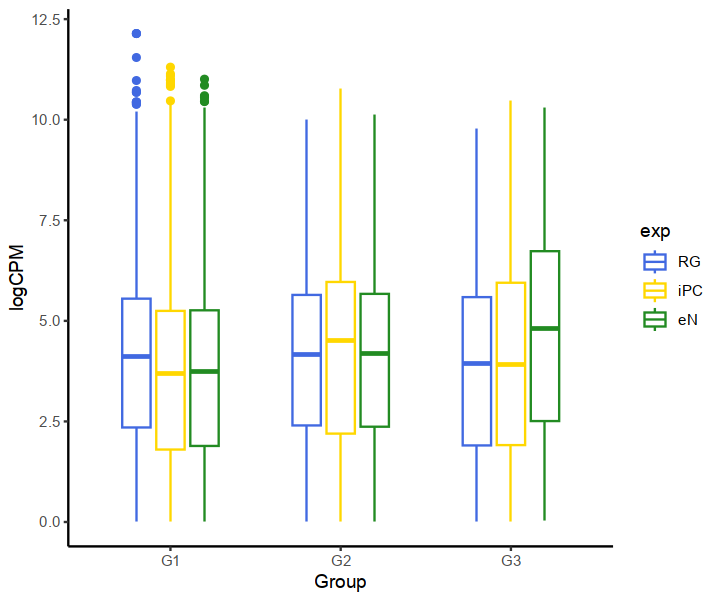

In [40]:
options(repr.plot.width=6,repr.plot.height=5)
ggplot(data = RNAplotDF %>% mutate(exp=factor(RNAplotDF$exp,levels=c("RG","iPC","eN"))),
       aes(x = Group, y = logCPM, color = exp)) +
  #geom_violin()+
  geom_boxplot(width=0.5,
               position = position_dodge(.6))+
  scale_color_manual(values = c("royalblue","gold","forestgreen"))+
#coord_cartesian(ylim = c(0,8))+
#geom_jitter(size=.1)+
#geom_sina(size=0.01,alpha=1)+
  theme_classic()

In [41]:
wilcox.test(G1.RNA.adjust$logRG,G1.RNA.adjust$logIPC,alternative = "greater")
wilcox.test(G1.RNA.adjust$logRG,G1.RNA.adjust$logeN,alternative = "greater")


	Wilcoxon rank sum test with continuity correction

data:  G1.RNA.adjust$logRG and G1.RNA.adjust$logIPC
W = 1079803, p-value = 3.644e-05
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  G1.RNA.adjust$logRG and G1.RNA.adjust$logeN
W = 1071150, p-value = 0.000181
alternative hypothesis: true location shift is greater than 0


In [42]:
wilcox.test(G2.RNA.adjust$logIPC,G2.RNA.adjust$logRG,alternative = "greater")
wilcox.test(G2.RNA.adjust$logIPC,G2.RNA.adjust$logeN,alternative = "greater")


	Wilcoxon rank sum test with continuity correction

data:  G2.RNA.adjust$logIPC and G2.RNA.adjust$logRG
W = 44722, p-value = 0.1202
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  G2.RNA.adjust$logIPC and G2.RNA.adjust$logeN
W = 44184, p-value = 0.1817
alternative hypothesis: true location shift is greater than 0


In [43]:
wilcox.test(G3.RNA.adjust$logeN,G2.RNA.adjust$logRG,alternative = "greater")
wilcox.test(G3.RNA.adjust$logeN,G2.RNA.adjust$logIPC,alternative = "greater")


	Wilcoxon rank sum test with continuity correction

data:  G3.RNA.adjust$logeN and G2.RNA.adjust$logRG
W = 33071, p-value = 0.009006
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  G3.RNA.adjust$logeN and G2.RNA.adjust$logIPC
W = 31381, p-value = 0.1005
alternative hypothesis: true location shift is greater than 0


In [39]:
library(gprofiler2)
library(clusterProfiler)
library(enrichplot)
library(DOSE)

In [40]:
G1res <- gost(query = unique(G1.RNA.adjust$V8),
organism = "hsapiens")
G2res <- gost(query = unique(G2.RNA.adjust$V8),
organism = "hsapiens")
G3res <- gost(query = unique(G3.RNA.adjust$V8),
organism = "hsapiens")

In [41]:
G1res$result %>% filter(source =="GO:BP") %>% 
arrange(p_value) %>%  
filter(term_size <= 5000) %>% 
select(p_value,source,term_size,term_name,intersection_size,term_id,p_value) %>%
distinct() %>% head()

,p_value,source,term_size,term_name,intersection_size,term_id
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>
1,2.588050e-09,GO:BP,4755,negative regulation of cellular process,304,GO:0048523
2,5.333097e-09,GO:BP,4822,macromolecule biosynthetic process,306,GO:0009059
3,8.287667e-08,GO:BP,4890,cellular nitrogen compound biosynthetic process,304,GO:0044271
4,1.248404e-07,GO:BP,2667,intracellular signal transduction,188,GO:0035556
5,1.281247e-07,GO:BP,1843,positive regulation of RNA metabolic process,142,GO:0051254
6,2.381183e-07,GO:BP,1703,positive regulation of DNA-templated transcription,133,GO:0045893


In [42]:
RNA <- RNA %>% mutate(logRG=log2(RG+1),logIPC=log2(IPC+1),logeN=log2(eN+1))

In [43]:
allRG.exp.gene <- RNA %>% filter(RG>0.5) %>% .$symbol %>% unique()
RG.exp.withoutSIO <- setdiff(allRG.exp.gene,unique(G1.RNA.adjust$V8))

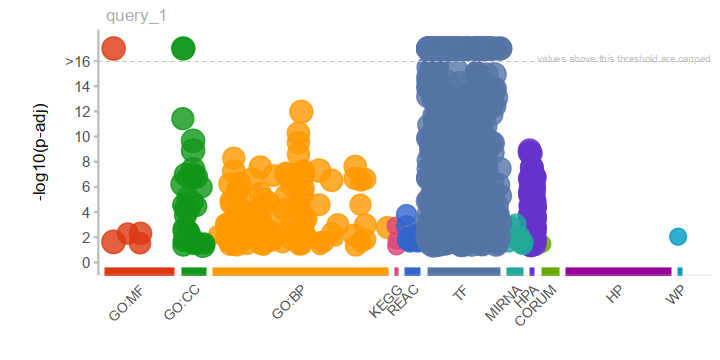

In [44]:
options(repr.plot.width=6,repr.plot.height=3)
gostplot(G1res, capped = T, interactive = F)

## enrich analysis

In [45]:
RG.sio_names = gconvert(unique(G1.RNA.adjust$V8))
IPC.sio_names = gconvert(unique(G2.RNA.adjust$V8))
eN.sio_names = gconvert(unique(G3.RNA.adjust$V8))

In [47]:
Groups.multi_gp = gost(list("RG" = RG.sio_names$name,
                            "iPC" = IPC.sio_names$name,
                            "eN" = eN.sio_names$name), 
                       multi_query = FALSE, evcodes = TRUE)

In [58]:
# modify the g:Profiler data frame
gp_mod =Groups.multi_gp$result[,c("query", "source", "term_id",
                                "term_name", "p_value", "query_size", 
                                "intersection_size", "term_size", 
                                "effective_domain_size", "intersection")]
gp_mod$GeneRatio = paste0(gp_mod$intersection_size,  "/", gp_mod$query_size)
gp_mod$BgRatio = paste0(gp_mod$term_size, "/", gp_mod$effective_domain_size)
names(gp_mod) = c("Cluster", "Category", "ID", "Description", "p.adjust", 
                    "query_size", "Count", "term_size", "effective_domain_size", 
                    "geneID", "GeneRatio", "BgRatio")
gp_mod$geneID = gsub(",", "/", gp_mod$geneID)
row.names(gp_mod) = paste0(gp_mod$ID,"-",gp_mod$Cluster)


In [96]:
# define as compareClusterResult object
gp_mod_cluster.BP = new("compareClusterResult", 
                     compareClusterResult = gp_mod %>% 
                     filter(Category=="GO:BP"))
gp_mod_cluster.TF = new("compareClusterResult", 
                     compareClusterResult = gp_mod %>% 
                     filter(Category=="TF"))

Warning message in order(as.numeric(unique(result$Cluster))):
“强制改变过程中产生了NA”


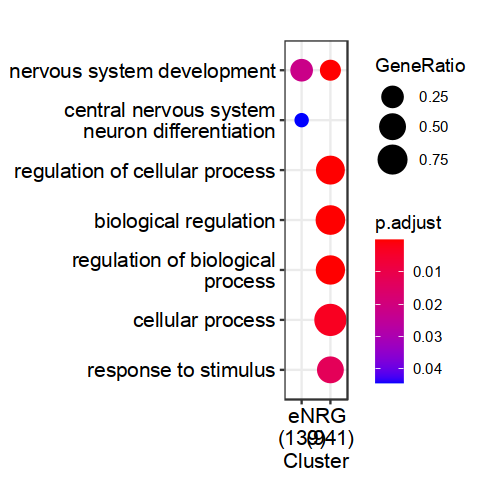

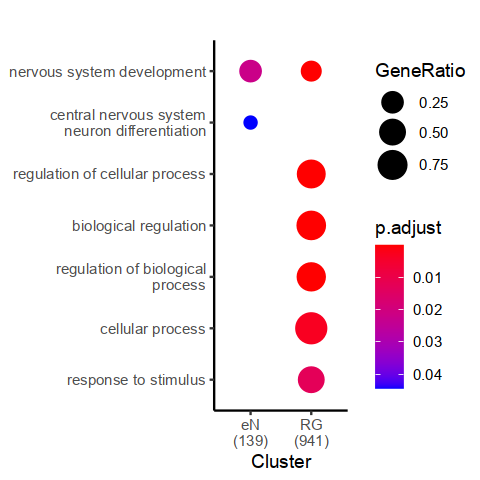

In [130]:
options(repr.plot.width=4,repr.plot.height=4)
enrichplot::dotplot(gp_mod_cluster.BP) + theme_classic() #+ 
#scale_color_gradientn(colours=c("blue","white","red"))
#scale_color_distiller(palette = "Spectral")
ggsave("../../../FINAL_figures/RGiPCeN_SIO_Gprofiler.BP.pdf",height = 4,width=4)